In [109]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore
import bambi as bmb
import arviz as az
import bammm.bammm as mm
import matplotlib.pyplot as plt
import networkx as nx
import json
from itertools import product, combinations



# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

no_trait_factors = 4
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==4:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
        #trait_factor_names_short = ["TF3", "TF2", "TF1","TA"]
        trait_factor_names_short = ["TF3", "TF2", "TF1"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 

mapdict = {'TF3_NegativeAffect': 'TF3',
        'TF2_PhysiolAnx': 'TF2', 
        'TF1_CognAnxDepr': 'TF1',
        'stai_ta': "TA",
        'covid_worry': 'Worry', 
        'prob_est': 'Probest',
        'q7_worry_econ_impact': 'EconWorr',
        'q6_apply_soc_dist': 'SocialDist',
        'q6_risk_group': 'RiskGr',
        'avoid_beh': 'AvoidBeh',
        'avoid_anx': 'AvoidAnx',
        'q6_media_freq_num': 'InforSeek',
        'q6_media_valence': 'MediaVal',
        'q7_period_rel_danger': 'DangerSate',
        'deaths': 'Deaths',
        'cases': 'Cases',
        'worryhealth': 'HealthWorry',
        'q6_work_home': "WorkHome",
        'sticsa_som_sa_currsess': "StateSomAnx",
    #    "q6_close_person_infdied": "ClosePDied",
        "covid_thoughts": "CovThoughts", 
        "memory_worry_infected_baselined": "MemWorry", 
        "memory_prob_infected_baselined": "MemProb", 

        #"affheallth-econ-worry": "Health>Econ \n worry", 
        #"covid_cases_est_diff": "Estimate of \n covid cases"
        }

vars = ["Worry", "Probest", "SocialDist", 
 "AvoidBeh", "AvoidAnx", "InforSeek", 
 "DangerSate", "Deaths", "WorkHome"]




vars= ["F1_exposure_anxiety","F2_covid_worry", "F3_infection_probability",  
                "F4_mixed_IS_closep", "F5_danger_perception", "F6_econ_worry", 
                "F7_skepticism", "F8_time_end_estimates", "F9_avoidance", "Deaths","Cases"]

vars = ["AvoidBeh","InforSeek", 
 "DangerSate", "Deaths", "Cases"]


vars = ["Worry", "Probest", 
 "AvoidBeh", "AvoidAnx", "InforSeek", 
 "DangerSate", "Deaths","Cases"]

vars = [ 
 "AvoidBeh", "InforSeek", 
 "DangerSate", "Deaths","Cases"]

vars= ["F1_exposure_anxiety","F2_covid_worry", "F3_infection_probability",  
                "F4_mixed_IS_closep", "F5_danger_perception", "F6_econ_worry", 
                "F7_skepticism", "F8_time_end_estimates", "F9_avoidance", "Deaths","Cases"]

df=df.rename(columns=mapdict)
dfall = df.copy()

df.loc[:,vars] = df.loc[:,vars].apply(zscore, nan_policy='omit')
df = df.loc[:,vars+["PROLIFICID","session"]]
tdf = df.pivot(columns="session", index="PROLIFICID", values=vars)


id_df = dfall.loc[:,["PROLIFICID","TF3", "TF2", "TF1", "TA"]].groupby(by=["PROLIFICID"]).mean()

/data/drive/postdoc/Project4_covid


In [110]:
#v = "Worry"
#vs = list(set(vars) - set([v]))
win= 2
model_family = "timelag_wo_traits_singleM_EFA"
samples = 1000
chains = 2
quickloadI = 0


ddf = pd.DataFrame()
for s in np.arange(win,20)+1:
    for vidx, v in enumerate(vars):
        y = demultindex(tdf.loc[:,(v,np.arange(s-win,s+1))])
        y = y.rename(columns=dict(zip(y.columns, [v+"_lag"+str(x) for x in np.arange(win,-1, -1)])))
        if vidx > 0: 
            yy = yy.join(y)
        else:
            yy = y
    yy["session"] = "sess"+str(s)
    ddf = pd.concat([ddf, yy])

ddf = ddf.join(id_df).reset_index()

if quickloadI == 0:
    fitdf = pd.DataFrame()
    for dv in vars: 
        print(dv)
        ivs = list(set(vars) - set([dv]))
        fxeff = [i+"_lag"+str(lg)+"*"+tt for i in ivs for tt in ["TF1" ,"TF2", "TF3"] for lg in [0,1,2]]
        dv_fxeff = [dv+"_lag"+str(lg)+"*"+tt for tt in ["TF1" ,"TF2", "TF3"] for lg in [1,2]]

        models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "timelag_model_db.json"), "r"))             
        model_key = model_family+"_window"+str(win)+"_"+dv+"_"+str(chains)+"_"+str(samples)

        if model_key in models.keys():
            mod = models[model_key]
        else:
            mod = mm.get_template()

        mod["type"] = "lmm"
        mod["lmm"]["dep_var"] = dv+"_lag0"
        mod["lmm"]["fxeff"] = fxeff + dv_fxeff + ["session"]
        #mod["lmm"]["fxeff"] = ["dv_lag1", "dv_lag2", "dv_lag3", "iv_lag1", "iv_lag2", "iv_lag3", "session"]
        mod["lmm"]["rneff"] = ["1|PROLIFICID"]
        mod["est"]["nchains"] = chains
        mod["est"]["nsamples"] = samples
        mod["est"]["tune"] = 500
        mod["family"] = model_family
        mod["name"] = model_key
        mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"], "reducedrank") 
        mod["location"] = os.path.join("output", "models", "model_data", model_family, mod["name"]+".dic" )
        mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
        mod, res, m = mm.estimate_lmm(mod=mod, data=ddf.dropna(), override=0)
        models[mod["name"]] = mod

        # save model
        mm.save_model_info(models, os.path.join(root_dir, "output", "models", "timelag_model_db.json"))


        ### gather into structure and save
        v2p1 = [i+"_lag"+str(lg)+":"+tt for i in ivs for tt in ["TF1" ,"TF2", "TF3"] for lg in [0,1,2]]
        v2p2 = [dv+"_lag"+str(lg)+":"+tt for tt in ["TF1" ,"TF2", "TF3"] for lg in [1,2]]
        v2p3 = [i+"_lag"+str(lg) for i in ivs for lg in [0,1,2]]
        v2p4 = [dv+"_lag"+str(lg) for lg in [1,2]]
        vars2plot = v2p1 + v2p2 + v2p3 + v2p4


        ttdf = pd.DataFrame()
        for tf in vars2plot:
            #print(tf+" "+lbl)
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"var"] = tf
            dt.loc[:,"dv"] = dv
            ttdf = pd.concat([ttdf, dt])

        #fitdf = pd.concat([fitdf, ttdf])


        #fitdf.to_csv(os.path.join(root_dir, "output",  "models", "model_data", "lagmodels_window"+str(win)+".csv"))
        ttdf.to_csv(os.path.join(root_dir, "output",  "models", "model_data", model_family,  dv+"_"+str(chains)+"_"+str(samples)+"_window"+str(win)+".csv"))
        fitdf = pd.concat([fitdf, ttdf])
    fitdf.to_csv(os.path.join(root_dir, "output",  "models", "model_data", model_family +"_all_"+str(chains)+"_"+str(samples)+"_window"+str(win)+".csv"))
elif quickloadI==1:
    fitdf = pd.DataFrame()
    for dv in vars: 
        fitdf = pd.concat([fitdf, pd.read_csv(os.path.join(root_dir, "output",  "models", "model_data", model_family,  dv+"_"+str(chains)+"_"+str(samples)+"_window"+str(win)+".csv"))])


F1_exposure_anxiety


KeyboardInterrupt: 

In [103]:
fitdf[['iv', 'ivrest']] = fitdf['var'].str.split('_', n=1, expand=True)
fitdf[['lag', 'trait']] = fitdf['ivrest'].str.split(':', n=1, expand=True)
fitdf['lag'] = fitdf['lag'].str.replace('_', '')



In [104]:
fitdf["var"].unique()

array(['Cases_lag0:TF1', 'Cases_lag1:TF1', 'Cases_lag2:TF1',
       'Cases_lag0:TF2', 'Cases_lag1:TF2', 'Cases_lag2:TF2',
       'Cases_lag0:TF3', 'Cases_lag1:TF3', 'Cases_lag2:TF3',
       'DangerSate_lag0:TF1', 'DangerSate_lag1:TF1',
       'DangerSate_lag2:TF1', 'DangerSate_lag0:TF2',
       'DangerSate_lag1:TF2', 'DangerSate_lag2:TF2',
       'DangerSate_lag0:TF3', 'DangerSate_lag1:TF3',
       'DangerSate_lag2:TF3', 'Deaths_lag0:TF1', 'Deaths_lag1:TF1',
       'Deaths_lag2:TF1', 'Deaths_lag0:TF2', 'Deaths_lag1:TF2',
       'Deaths_lag2:TF2', 'Deaths_lag0:TF3', 'Deaths_lag1:TF3',
       'Deaths_lag2:TF3', 'InforSeek_lag0:TF1', 'InforSeek_lag1:TF1',
       'InforSeek_lag2:TF1', 'InforSeek_lag0:TF2', 'InforSeek_lag1:TF2',
       'InforSeek_lag2:TF2', 'InforSeek_lag0:TF3', 'InforSeek_lag1:TF3',
       'InforSeek_lag2:TF3', 'AvoidBeh_lag1:TF1', 'AvoidBeh_lag2:TF1',
       'AvoidBeh_lag1:TF2', 'AvoidBeh_lag2:TF2', 'AvoidBeh_lag1:TF3',
       'AvoidBeh_lag2:TF3', 'Cases_lag0', 'Cases_lag

In [105]:
bounds = fitdf.groupby(by=["var", "dv", "iv"])['sample'].quantile((0.025,0.5,0.975)).unstack().reset_index().sort_values(by="var")


In [106]:
bounds.loc[(bounds["var"].str.contains("lag0")) & ~(bounds["var"].str.contains("TF")),:]

var          dv          iv     0.025       0.5     0.975
0      AvoidBeh_lag0       Cases    AvoidBeh -0.011186  0.008784  0.028362
1      AvoidBeh_lag0  DangerSate    AvoidBeh  0.081140  0.124456  0.165004
2      AvoidBeh_lag0      Deaths    AvoidBeh -0.008043  0.009084  0.026619
3      AvoidBeh_lag0   InforSeek    AvoidBeh  0.016638  0.053494  0.090115
56        Cases_lag0    AvoidBeh       Cases -0.013370  0.025693  0.065651
57        Cases_lag0  DangerSate       Cases  0.010929  0.071545  0.129284
58        Cases_lag0      Deaths       Cases  0.213322  0.237106  0.262398
59        Cases_lag0   InforSeek       Cases -0.014263  0.036438  0.085933
115  DangerSate_lag0   InforSeek  DangerSate  0.050420  0.074890  0.100085
114  DangerSate_lag0      Deaths  DangerSate -0.014788 -0.002260  0.009547
113  DangerSate_lag0       Cases  DangerSate  0.003225  0.016493  0.030065
112  DangerSate_lag0    AvoidBeh  DangerSate  0.040859  0.060020  0.080726
170      Deaths_lag0  DangerSate      Deaths -0.071131 -0.007636  0.056175
171      Deaths_lag0   InforSeek      Deaths -0.041082  0.014273  0.069165
168      Deaths_lag0    AvoidBeh      Deaths -0.034457  0.011790  0.058100
169      Deaths_lag0       Cases      Deaths  0.266730  0.297413  0.327524
227   InforSeek_lag0      Deaths   InforSeek -0.008633  0.006404  0.021076
226   InforSeek_lag0  DangerSate   InforSeek  0.067572  0.101411  0.133502
224   InforSeek_lag0    AvoidBeh   InforSeek  0.013964  0.036581  0.060237
225   InforSeek_lag0       Cases   InforSeek -0.007152  0.008627  0.025545

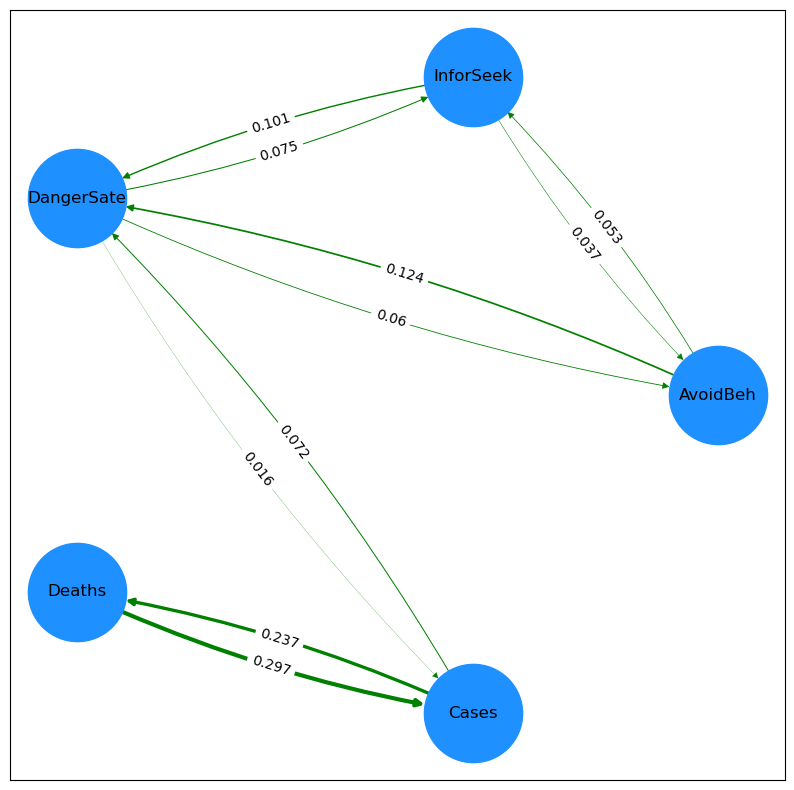

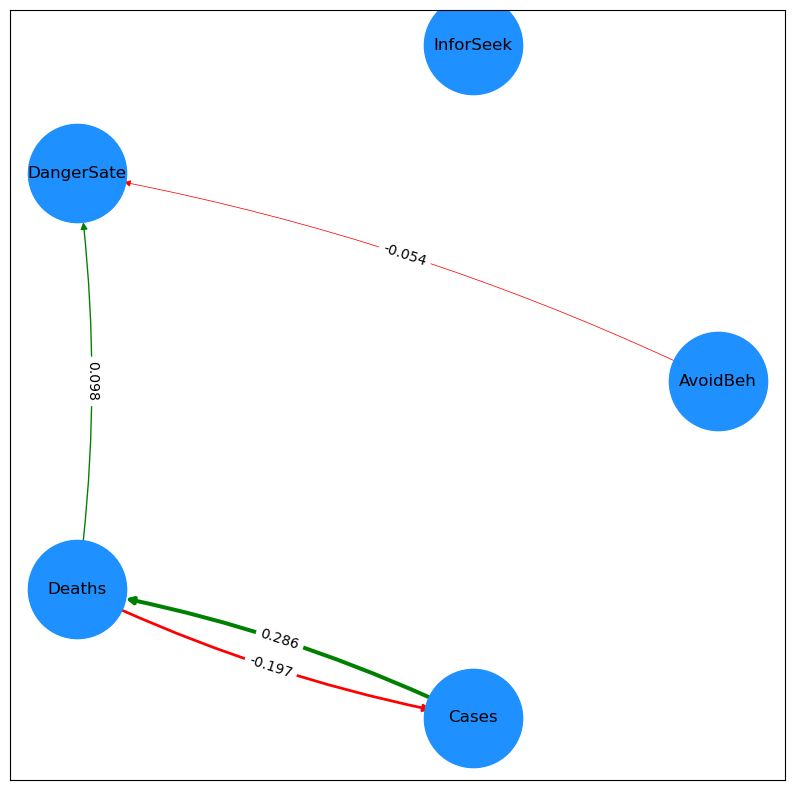

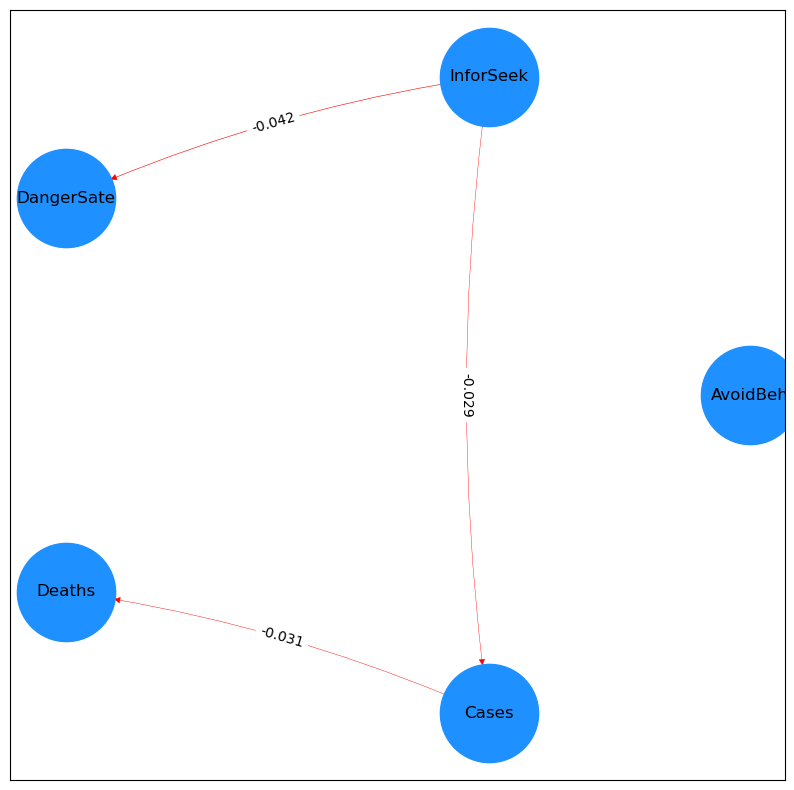

In [107]:
# get data

for lg in range(3):
    # filter to get the right regressors
    bdf = bounds.loc[(bounds["var"].str.contains("lag"+str(lg))) & ~(bounds["var"].str.contains("TF")) & (bounds["iv"]!=bounds["dv"]),:]
    bdf["sig"]  = ["ns" if l<0<u else "s" for l,u in zip(bdf[0.025], bdf[0.975])]
    bdf = bdf.loc[bdf["sig"]=="s",:]
    combs = dict([((iv, dv), "x") for dv, iv in zip(bdf["dv"], bdf["iv"])])
    edge_colors = ["green" if x>=0 else "red" for x in bdf[0.5]]

    import matplotlib
    import matplotlib.cm as cm

    # Prepare bodes, edges and layouts 
    G = nx.DiGraph()
    G.add_nodes_from(vars)
    G.add_edges_from(combs)
    edge_labels = dict([((iv, dv), round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),0.5]),3)) for iv, dv in zip(bdf["iv"],bdf["dv"])])
    edge_widths = np.array([round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),0.5]),3) for iv, dv in zip(bdf["iv"],bdf["dv"])])
    #norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
    #mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)

    nodesize = 5000
    arc_rad = 0.07
    pos=nx.circular_layout(G)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_shape="o", node_size=nodesize, node_color='dodgerblue')
    nx.draw_networkx_labels(G, pos, ax=ax)

    nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths*10, edgelist=combs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True, arrowsize=10, node_size=nodesize)
    #fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

    my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax,  rad=arc_rad)
    plt.show()

### with traits 

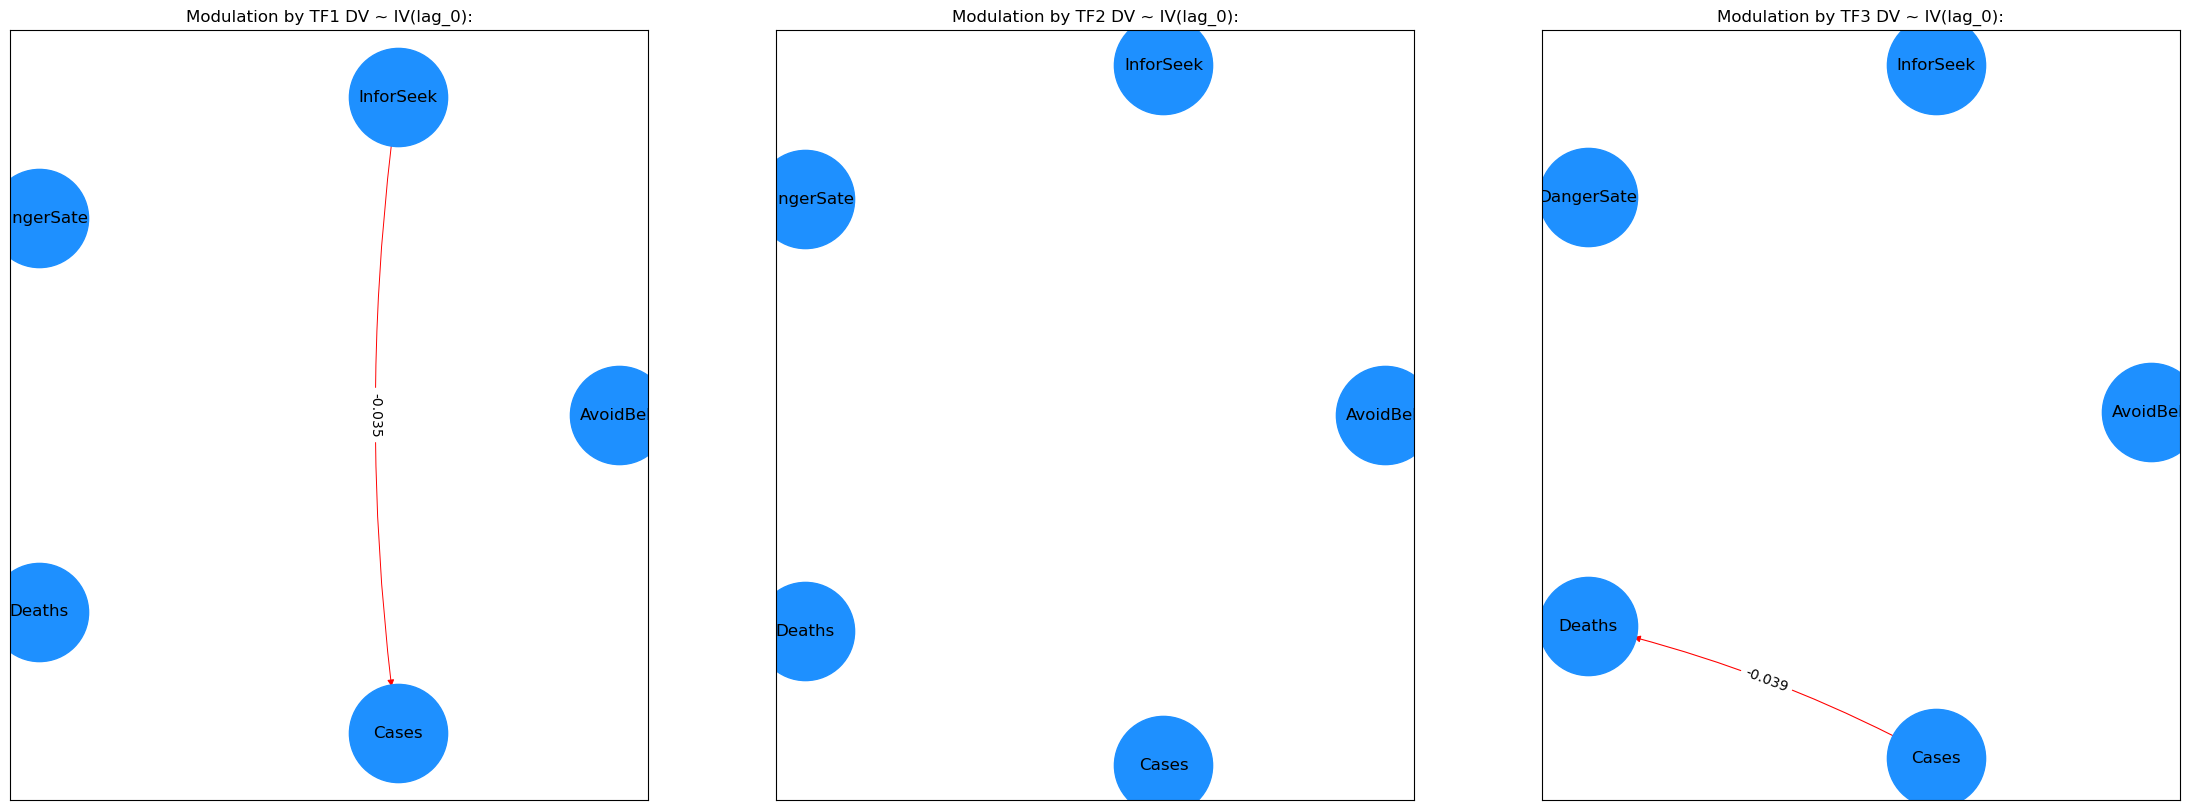

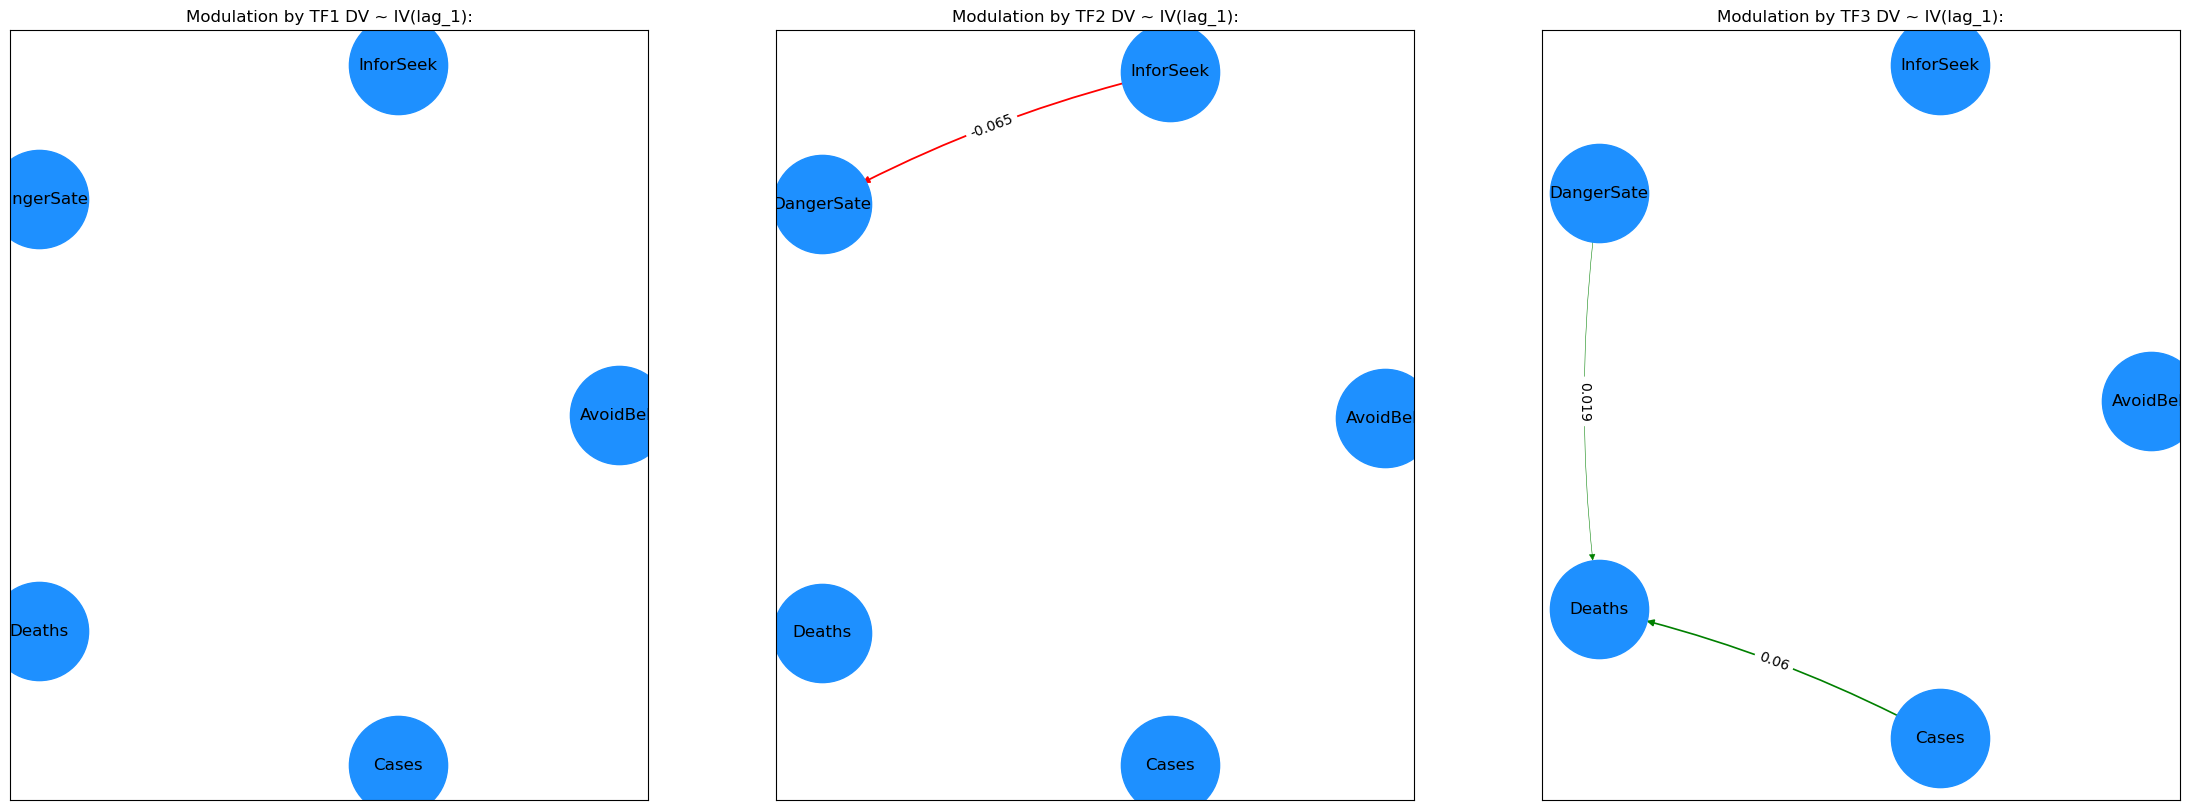

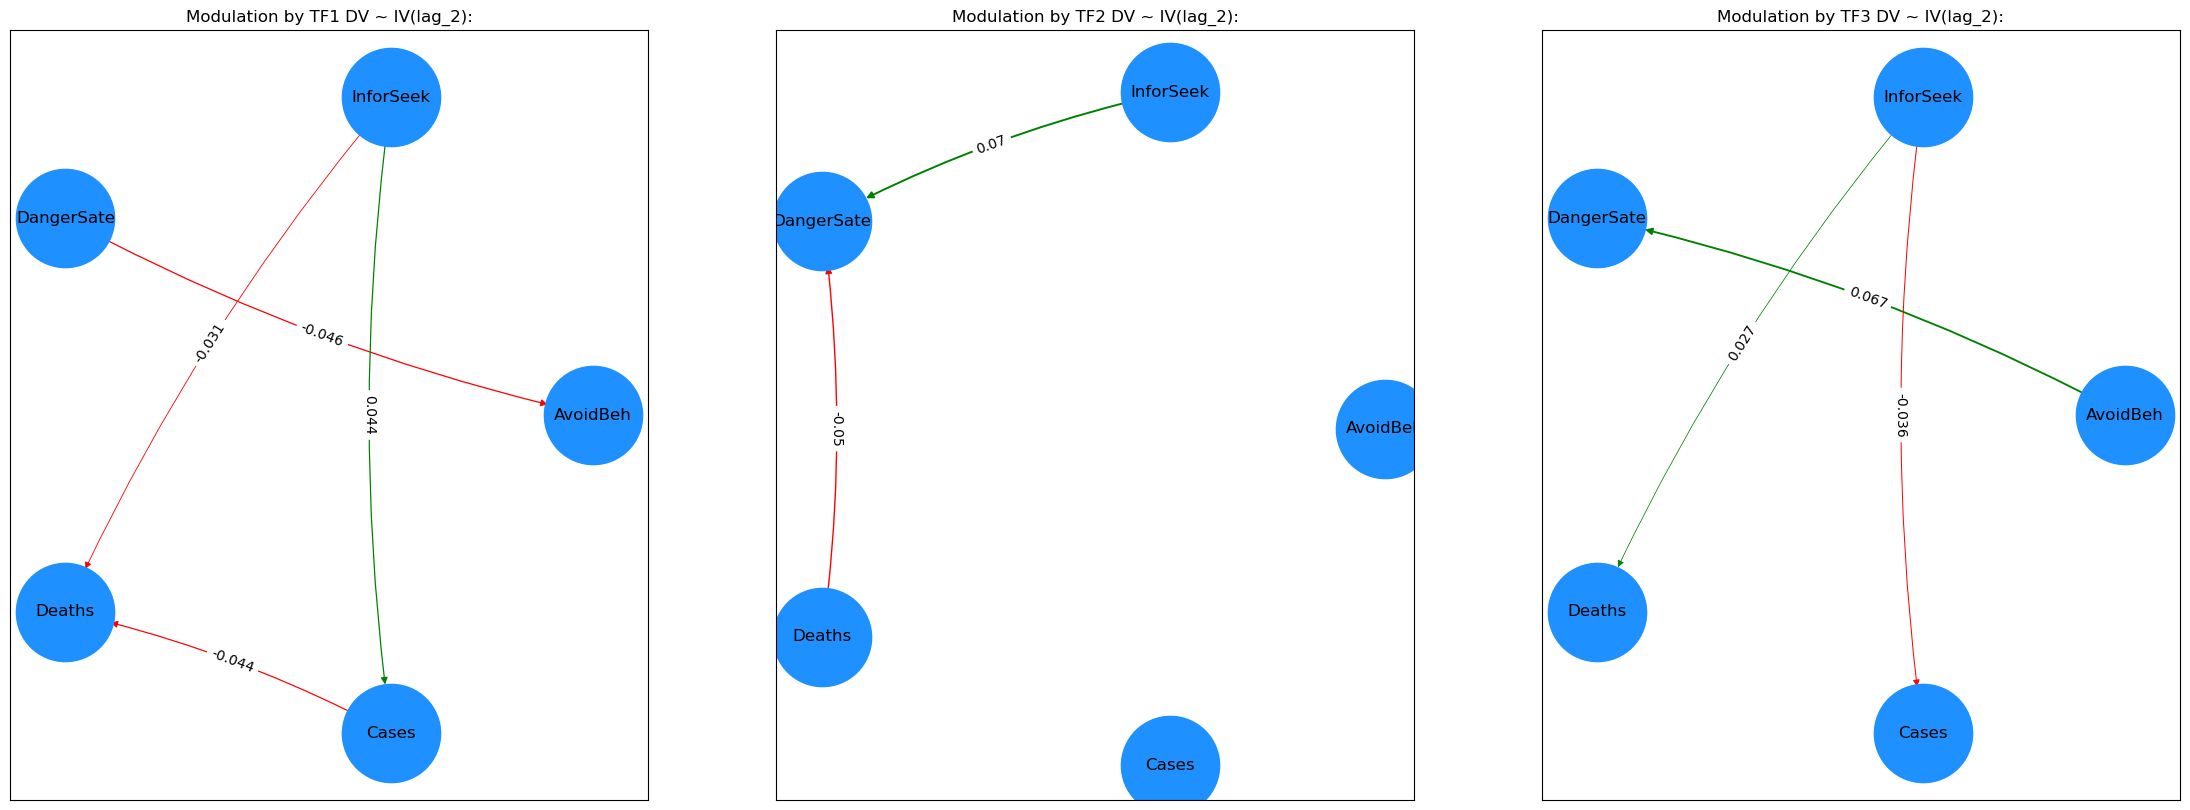

In [108]:
conds = {"varname":["lag0", "lag1", "lag2"], 
         "label":["DV ~ IV(lag_0):", "DV ~ IV(lag_1):", "DV ~ IV(lag_2):"]}

for v, lbl in zip(conds["varname"], conds["label"]):
    # get data
    #bounds = fitdf.groupby(by=["var", "label", "iv", "dv"])['sample'].quantile((0.025,0.5,0.975)).unstack().reset_index().sort_values(by="var")
    fig, ax = plt.subplots(1,3,figsize=(28,10))
    for tidx, trait in enumerate(["TF1", "TF2", "TF3"]):
        # filter for same session and only "significant" 
        bdf = bounds.loc[(bounds["var"].str.contains(v)) & (bounds["var"].str.contains(trait)) & (bounds["iv"]!=bounds["dv"]),:]
        #bdf = bounds.loc[bounds["var"]==v+":"+trait,:]
        bdf["sig"]  = ["ns" if l<0<u else "s" for l,u in zip(bdf[0.025], bdf[0.975])]
        bdf = bdf.loc[bdf["sig"]=="s",:]
        combs = dict([((iv, dv), "x") for dv, iv in zip(bdf["dv"], bdf["iv"])])
        edge_colors = ["green" if x>=0 else "red" for x in bdf[0.5]]

        import matplotlib
        import matplotlib.cm as cm

        # Prepare bodes, edges and layouts 
        G = nx.DiGraph()
        G.add_nodes_from(vars)
        G.add_edges_from(combs)
        edge_labels = dict([((iv, dv), round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),0.5]),3)) for iv, dv in zip(bdf["iv"],bdf["dv"])])
        edge_widths = np.array([round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),0.5]),3) for iv, dv in zip(bdf["iv"],bdf["dv"])])
        #norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
        #mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)

        nodesize = 5000
        arc_rad = 0.07
        pos=nx.circular_layout(G)
        
        nx.draw_networkx_nodes(G, pos, ax=ax[tidx], node_shape="o", node_size=nodesize, node_color='dodgerblue')
        nx.draw_networkx_labels(G, pos, ax=ax[tidx])

        nx.draw_networkx_edges(G, pos, ax=ax[tidx], width=edge_widths*20, edgelist=combs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True, arrowsize=10, node_size=nodesize)
        #fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

        my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax[tidx],  rad=arc_rad)
        ax[tidx].set_title("Modulation by "+trait+" "+ lbl)
    plt.show()
